# Library



In [2]:
import csv
from tqdm.auto import tqdm
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import copy
import torch.optim as optim

# Data Changing For Training

## First data processing
- remove some data that not need in this project
- change play_time to rating

In [3]:
df = pd.read_csv('steam-200k.csv', header=None, names=['user_id', 'game', 'behavior', 'ratings', 'unused'])

df = df[df['behavior'] != 'purchase']
df = df[df['unused'] != '0']

df = df[df['ratings'] >= 2.0]
#df = df[df['ratings'] <= 500.0]
#df['ratings'] = (df['ratings'] / df['ratings'].max()) * 5


def change_ratings(rating):
  if rating <= 5:
    return 1
  elif rating <= 20:
    return 2
  elif rating <= 50:
    return 3
  elif rating <= 200:
    return 4
  else:
    return 5

df['ratings'] = df['ratings'].apply(change_ratings)

df.to_csv('filtered_steam_data.csv', index=False)



<ipython-input-3-34524843d495>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ratings'] = df['ratings'].apply(change_ratings)


In [4]:
headers = ['user_id', 'game', 'unused', 'ratings', '0']
steam_data = pd.read_csv('filtered_steam_data.csv', sep=',', names=headers)
steam_data = steam_data.drop(['0'],axis=1)
steam_data = steam_data.sort_values(by=['ratings'])

steam_data

,user_id,game,unused,ratings
45535,128470551,Magic Duels,play,1
15822,138941587,Paranormal State Poison Spring Collector's Edi...,play,1
15823,138941587,Dracula's Legacy,play,1
15824,138941587,Hammerwatch,play,1
15825,138941587,Nightmares from the Deep 2 The Siren`s Call,play,1
...,...,...,...,...
14121,145908178,Dota 2,play,5
39103,198081354,Counter-Strike Global Offensive,play,5
14085,300248088,Dota 2,play,5
42477,47457723,Kerbal Space Program,play,5


In [5]:
df = pd.read_csv('steam-200k.csv', header=None, names=['user_id', 'game', 'behavior', 'value', 'extra'])

unique_games = df['game'].unique()

numbered_games = {game: idx+1 for idx, game in enumerate(unique_games)}

result = [(number, game) for game, number in numbered_games.items()]

with open('numbered_games.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['Number', 'Game'])
    writer.writerows(result)

gamenum = pd.read_csv('numbered_games.csv')
gamenum

,Number,Game
0,1,The Elder Scrolls V Skyrim
1,2,Fallout 4
2,3,Spore
3,4,Fallout New Vegas
4,5,Left 4 Dead 2
...,...,...
5150,5151,Warriors & Castles
5151,5152,Romance of the Three Kingdoms Maker
5152,5153,Space Colony
5153,5154,Life is Hard


In [6]:
numbered_games = pd.read_csv('numbered_games.csv')
steam_data = pd.read_csv('filtered_steam_data.csv')

merged_data = pd.merge(steam_data, numbered_games[['Number', 'Game']],
                       left_on='game', right_on='Game', how='left')

merged_data = merged_data.drop('Game', axis=1)
cols = merged_data.columns.tolist()
cols = ['Number'] + [col for col in cols if col != 'Number']
merged_data = merged_data[cols]

merged_data.to_csv('filtered_steam_data_with_numbers.csv', index=False)

fsdwn = pd.read_csv('filtered_steam_data_with_numbers.csv')
fsdwn

,Number,user_id,game,behavior,ratings,unused
0,1,151603712,The Elder Scrolls V Skyrim,play,5,0
1,2,151603712,Fallout 4,play,4,0
2,3,151603712,Spore,play,2,0
3,4,151603712,Fallout New Vegas,play,2,0
4,5,151603712,Left 4 Dead 2,play,2,0
...,...,...,...,...,...,...
45530,1994,128470551,Nether,play,1,0
45531,129,128470551,Rogue Legacy,play,1,0
45532,986,128470551,Mortal Kombat Komplete Edition,play,1,0
45533,29,128470551,Fallen Earth,play,1,0


### Check data distribution

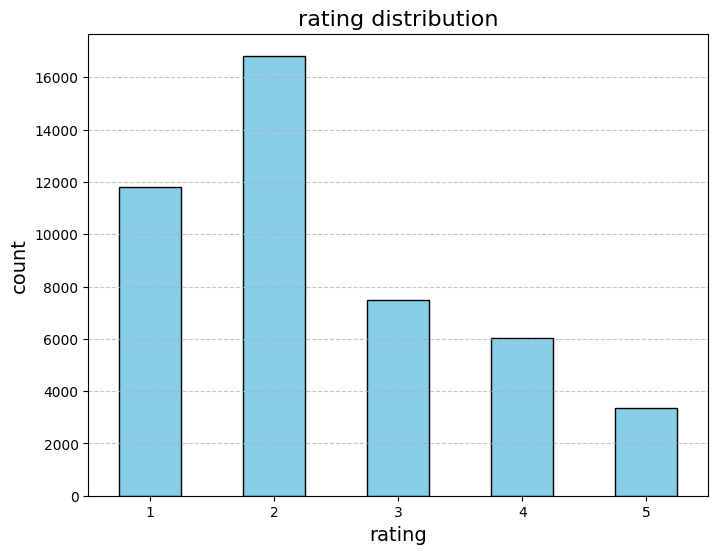

In [7]:

df = pd.read_csv('filtered_steam_data_with_numbers.csv')

bins = [0, 1, 2, 3, 4, 5]
labels = ['1', '2', '3', '4', '5']
df['rating_bins'] = pd.cut(df['ratings'], bins=bins, labels=labels, include_lowest=True)

bin_counts = df['rating_bins'].value_counts(sort=False)

plt.figure(figsize=(8, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('rating distribution', fontsize=16)
plt.xlabel('rating', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



# Functions

In [8]:
class RatingSet:
    def __init__(self, csv_path='filtered_steam_data_with_numbers.csv'):
        self.ratings = pd.read_csv(csv_path)

        self.n_users = len(set(self.ratings['user_id']))
        self.n_games = len(set(self.ratings['Number']))

        self.user_ids = list(set(self.ratings['user_id']))
        self.games = sorted(list(set(self.ratings['Number'])))

        self.game2idx = {id: idx for idx, id in enumerate(self.games)}
        self.user2idx = {id: idx for idx, id in enumerate(self.user_ids)}

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        idx_row = self.ratings.iloc[idx]

        user_id = self.user2idx[idx_row.user_id]
        Number_id = self.game2idx[idx_row.Number]
        rating = idx_row.ratings

        return user_id, Number_id, torch.tensor(rating, dtype=torch.float32)


class MatrixFactorizer(nn.Module):
    def __init__(self, n_user, n_game, n_factor):
        super().__init__()
        self.user_embedding = nn.Embedding(n_user, n_factor)
        self.game_embedding = nn.Embedding(n_game, n_factor)

        self.user_embedding.weight.data /= n_factor ** 0.5
        self.game_embedding.weight.data /= n_factor ** 0.5
        self.scale = 5.5

    def scaled_sigmoid(self, x):
        return 1 / (1 + torch.exp(-x / self.scale)) * self.scale

    def forward(self, user_id, Number_id):
        user_emb_vec = self.user_embedding(user_id)
        game_emb_vec = self.game_embedding(Number_id)
        dot_prod_result = torch.einsum('ij,ij->i', user_emb_vec, game_emb_vec)
        return self.scaled_sigmoid(dot_prod_result)


class MatrixFactorizerWithBias(MatrixFactorizer):
    def __init__(self, n_user, n_game, n_factor):
        super().__init__(n_user, n_game, n_factor)
        self.user_bias = nn.Embedding(n_user, 1)
        self.game_bias = nn.Embedding(n_game, 1)
        #self.user_bias.weight.data = torch.zeros(n_user, 1)
        #.game_bias.weight.data = torch.zeros(n_game, 1)
        self.user_bias.weight.data.uniform_(-0.0001, 0.0001)
        self.game_bias.weight.data.uniform_(-0.0001, 0.0001)

    def forward(self, user_id, Number_id):
        user_emb_vec = self.user_embedding(user_id)
        game_emb_vec = self.game_embedding(Number_id)

        dot_prod_result = torch.einsum('ij,ij->i', user_emb_vec, game_emb_vec)
        dot_prod_result += self.user_bias(user_id)[:, 0] + self.game_bias(Number_id)[:, 0]

        return self.scaled_sigmoid(dot_prod_result)


class Trainer:
    def __init__(self, model, train_loader, valid_loader, model_name='steamgamerec', device='cpu'):
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.device = device
        self.model.to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.acc_threshold = 0.5
        self.best_loss = torch.inf
        self.best_acc = 0.0
        self.train_losses = []
        self.valid_losses = []
        self.train_accs = []
        self.valid_accs = []
        self.model_name = model_name
        self.model_states = []

    def validation(self):
        self.model.eval()
        current_loss = 0
        num_total_correct_pred = 0
        with torch.no_grad():
            for batch in self.valid_loader:
                user_ids, games, ratings = batch
                user_ids, games, ratings = (
                    user_ids.to(self.device),
                    games.to(self.device),
                    ratings.to(self.device),
                )

                outputs = self.model(user_ids, games)
                loss = self.criterion(outputs, ratings)
                num_acc_pred = (torch.abs(outputs - ratings) < self.acc_threshold).sum()
                num_total_correct_pred += num_acc_pred.item()
                current_loss += loss.item() * len(ratings)

        mean_loss = current_loss / len(self.valid_loader.dataset)
        mean_acc = num_total_correct_pred / len(self.valid_loader.dataset)
        return mean_loss, mean_acc

    def train_by_number_of_epochs(self, num_epochs):
        for epoch in tqdm(range(num_epochs)):
            self.model.train()
            for batch in tqdm(self.train_loader, leave=False):
                user_ids, games, ratings = batch
                user_ids, games, ratings = (
                    user_ids.to(self.device),
                    games.to(self.device),
                    ratings.to(self.device),
                )
                self.optimizer.zero_grad()
                outputs = self.model(user_ids, games)
                loss = self.criterion(outputs, ratings)
                acc = (torch.abs(outputs - ratings) < self.acc_threshold).sum() / len(ratings)
                loss.backward()
                self.optimizer.step()

                self.train_losses.append(loss.item())
                self.train_accs.append(acc.item())

            valid_loss, valid_acc = self.validation()
            if valid_acc > self.best_acc:
                self.best_acc = valid_acc
                models_parameters = self.model.state_dict()
                print(f"Saving best model at epoch {len(self.valid_accs)}, acc: {round(valid_acc,3)}")
                torch.save(models_parameters, f'{self.model_name}_best.pt')

            self.model_states.append(copy.deepcopy(self.model.state_dict()))
            self.valid_losses.append(valid_loss)
            self.valid_accs.append(valid_acc)

        plt.plot(self.train_accs, label="Train Accuracy")
        plt.plot(
            range(len(self.train_loader) - 1, len(self.train_accs), len(self.train_loader)),
            self.valid_accs,
            label="Validation Accuracy",
        )
        plt.legend()
        plt.title("Accuracy")
        plt.show()

# Way To Training Model

In [24]:
games = pd.read_csv('numbered_games.csv')
ratings = pd.read_csv('filtered_steam_data_with_numbers.csv')

games = games[games['Number'].isin(ratings['Number'])]
games.reset_index(drop=True, inplace=True)
games['Game'].to_csv("list_of_game_titles.csv", index=False)

dataset = RatingSet()
num_train = int(len(dataset)*0.90)
num_valid = int(len(dataset)*0.05)
num_test = len(dataset) - num_train - num_valid
train_set, valid_set, test_set = torch.utils.data.random_split(dataset,
                                              [num_train, num_valid, num_test],
                                               generator=torch.Generator().manual_seed(0))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/641 [00:00<?, ?it/s]

Saving best model at epoch 0, acc: 0.163


  0%|          | 0/641 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bd25f3b2710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bd25f3b2710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Saving best model at epoch 1, acc: 0.207


  0%|          | 0/641 [00:00<?, ?it/s]

Saving best model at epoch 2, acc: 0.249


  0%|          | 0/641 [00:00<?, ?it/s]

Saving best model at epoch 3, acc: 0.268


  0%|          | 0/641 [00:00<?, ?it/s]

Saving best model at epoch 4, acc: 0.283


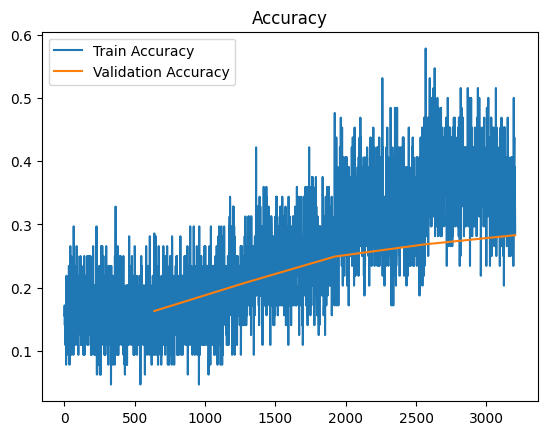

In [35]:
n_factors = 70
n_epochs = 5
learning_rate = 2e-3

model = MatrixFactorizerWithBias(dataset.n_users, dataset.n_games, n_factors)

trainer = Trainer(
    model,
    train_loader,
    valid_loader,
    device='cpu'
)
trainer.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

trainer.train_by_number_of_epochs(n_epochs)


In [36]:
model.load_state_dict(torch.load('steamgamerec_best.pt'))
game_embs = model.game_embedding.weight.detach().cpu()
game_bias = model.game_bias.weight.detach().cpu()

<ipython-input-36-a70aa8937900>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('steamgamerec_best.pt'))


In [37]:
indices = torch.argsort(game_bias.squeeze(), descending=True)
indices = indices.tolist()
pd.set_option('display.min_rows', 10) # you can set number of print rows by this line
pd.DataFrame({"title": list(gamenum['Game'].iloc[indices]), "bias": game_bias[indices].squeeze().tolist()})

,title,bias
0,Company of Heroes Tales of Valor,1.623417
1,Shatter,1.342042
2,Tomb Raider The Last Revelation,1.310458
3,Call of Duty Modern Warfare 3,1.272724
4,Men of War Assault Squad,1.192600
...,...,...
2795,Shank,-1.431922
2796,Resident Evil Revelations / Biohazard Revelations,-1.603384
2797,PROTOTYPE 2,-1.604097
2798,PAYDAY The Heist,-1.614584


# Let's Calculate Similarity

In [38]:
def get_cosine_sim(emb, embs, eps=1e-8):
  with torch.no_grad():
    return torch.sum(emb * embs, dim=1) / (torch.sum(emb**2) * torch.sum(embs**2, dim=-1) + eps) ** 0.5

# Result

In [54]:
game_embs = model.game_embedding.weight.cpu()
sel_game_id = 200 # max is 2514
sims = get_cosine_sim(game_embs[sel_game_id], game_embs)
sims[sel_game_id]=0
_, indices = torch.sort(sims, descending=True)
indices = indices[:5].tolist()
print(f"Titles of selected game_id is: {games.iloc[sel_game_id]['Game']}")
pd.DataFrame({"title": list(games['Game'].iloc[indices]), "similarity": sims[indices].tolist()}).head()


Titles of selected game_id is: Dead Island


,title,similarity
0,Impire,0.831976
1,Shovel Knight,0.813929
2,Sorcerer King,0.806816
3,MASSIVE CHALICE,0.805706
4,Hell Yeah!,0.804188
